In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

Author: Wesley Oke

Question:
Can Machine Learning predict how neighbourhoods will be impacted by COVID?

Approach:
1. Calculate the total number of COVID cases per 100,000 people for each neighbourhood.  Identify or create appropriate neighbourhoood features that might impact the number of cases (density, wealth, average age?, etc).  Apply correlation(?), linear regression, decision trees(?), random forests(?) etc. to determine how the various features (risk factors) may impact the COVID infection rate.

In [2]:
cov19 = pd.read_csv('https://raw.githubusercontent.com/oke-w/covid/main/COVID19%20cases.csv', true_values=['Yes'], false_values=['No'])

In [3]:
cov19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     38656 non-null  int64 
 1   Assigned_ID             38656 non-null  int64 
 2   Outbreak Associated     38656 non-null  object
 3   Age Group               38624 non-null  object
 4   Neighbourhood Name      37649 non-null  object
 5   FSA                     37826 non-null  object
 6   Source of Infection     38656 non-null  object
 7   Classification          38656 non-null  object
 8   Episode Date            38656 non-null  object
 9   Reported Date           38656 non-null  object
 10  Client Gender           38656 non-null  object
 11  Outcome                 38656 non-null  object
 12  Currently Hospitalized  38656 non-null  bool  
 13  Currently in ICU        38656 non-null  bool  
 14  Currently Intubated     38656 non-null  bool  
 15  Ev

In [4]:
cov19.dropna(subset=['Neighbourhood Name'], inplace=True) # drop rows that don't have identified Neighbourhood
cov_count = cov19.groupby('Neighbourhood Name')['_id'].count() # create a Series of neighbourhoods and case counts
type(cov_count)

pandas.core.series.Series

In [5]:
# change the Yes/No values into 'True'/'' values and convert to boolean (True/False)
#cov19.iloc[:,15:18] = cov19.iloc[:,15:18].applymap(lambda x: '' if x == 'No' else 'True').astype(bool)

In [6]:
# create a DF neighbourhoods with ID#, hospitalized, ICU, and intubated counts
temp = cov19.groupby('Neighbourhood Name').sum().iloc[:,2:5]

In [7]:
cov_counts = pd.concat([cov_count,temp],axis=1)
cov_counts.columns = 'cov_counts', 'hospitalized_counts', 'ICU_counts', 'intubated_counts'

In [8]:
cov_counts

,cov_counts,hospitalized_counts,ICU_counts,intubated_counts
Neighbourhood Name,,,,
Agincourt North,292,1,0,0
Agincourt South-Malvern West,204,1,0,0
Alderwood,124,0,0,0
Annex,278,1,1,1
Banbury-Don Mills,160,2,0,0
...,...,...,...,...
Wychwood,141,1,1,0
Yonge-Eglinton,62,0,0,0
Yonge-St.Clair,60,0,0,0


In [9]:
cov_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   cov_counts           140 non-null    int64
 1   hospitalized_counts  140 non-null    int64
 2   ICU_counts           140 non-null    int64
 3   intubated_counts     140 non-null    int64
dtypes: int64(4)
memory usage: 5.5+ KB


Note, the nbhd source data Neighbourhood Names were edited as follows:
- Nbhd 59: "Danforth-East York"
- Covid: "Weston-Pelham Park"
- Covid: "Briar Hill-Belgravia"

In [10]:
git = 'https://raw.githubusercontent.com/oke-w/covid/main/neighbourhood-profiles-2016-cleaned-short.csv'
nbhd = pd.read_csv(git, header=[2], index_col=[0], thousands=',')

In [11]:
nbhd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 39 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Neighbourhood Name                                                   141 non-null    object 
 1   Population, 2016                                                     141 non-null    int64  
 2   Population density per square kilometre                              141 non-null    int64  
 3    Average household size                                              141 non-null    float64
 4     Average after-tax income of households in 2015 ($)                 141 non-null    int64  
 5   Children (0-14 years)                                                141 non-null    int64  
 6   Youth (15-24 years)                                                  141 non-null    int64  
 7   Working 

In [12]:
nbhd.head()

,Neighbourhood Name,"Population, 2016",Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Seniors (65+ years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
0,City of Toronto,2731571,4334,2.42,81495,398135,340270,1229555,336670,426945,...,55770,53385,98910,86755,75120,63360,51570,94020,58260,111185
1,West Humber-Clairville,33312,1117,3.20,426156,5060,5445,13845,3990,4980,...,495,545,1005,1045,815,760,595,1150,645,565
2,Mount Olive-Silverstone-Jamestown,32954,7291,3.32,360648,7090,5240,13615,3475,3560,...,670,660,1160,980,765,585,445,690,300,225
3,Thistletown-Beaumond Heights,10360,3130,3.09,140050,1730,1410,4160,1195,1880,...,185,170,340,290,240,200,185,340,190,190
4,Rexdale-Kipling,10529,4229,2.69,134305,1640,1355,4300,1520,1730,...,195,210,360,305,270,270,220,395,180,170


In [13]:
#ind = 'Neighbourhood Information', 'Neighbourhood Information', 'Neighbourhood Name')
nbhd_cov = pd.merge(cov_counts, nbhd, left_index=True, right_on='Neighbourhood Name')

In [14]:
nbhd_cov # should have 140 rows!

,cov_counts,hospitalized_counts,ICU_counts,intubated_counts,Neighbourhood Name,"Population, 2016",Population density per square kilometre,Average household size,Average after-tax income of households in 2015 ($),Children (0-14 years),...,"$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 and over"
Characteristic,,,,,,,,,,,,,,,,,,,,,
129,292,1,0,0,Agincourt North,29113,3929,3.16,427037,3840,...,455,475,930,755,695,640,500,935,465,510
128,204,1,0,0,Agincourt South-Malvern West,23757,3034,2.88,278390,3075,...,470,445,860,755,630,500,405,700,370,425
20,124,0,0,0,Alderwood,12054,2435,2.60,168602,1760,...,185,225,390,355,365,310,265,605,445,470
95,278,1,1,1,Annex,30526,10863,1.80,792507,2360,...,645,665,1160,1060,820,750,620,1205,780,2765
42,160,2,0,0,Banbury-Don Mills,27695,2775,2.23,493486,3605,...,555,575,1180,1000,790,690,595,1030,660,1915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,141,1,1,0,Wychwood,14349,8541,2.24,239484,1860,...,280,225,500,400,380,305,250,495,310,705
100,62,0,0,0,Yonge-Eglinton,11817,7162,2.08,222648,1800,...,240,240,475,415,345,255,240,465,320,1135
97,60,0,0,0,Yonge-St.Clair,12528,10708,1.76,541217,1210,...,330,315,625,475,450,335,305,570,350,1390


In [15]:
# carry out Linear Regression with single column "Population"
X = nbhd_cov.iloc[:,5].values.reshape(-1, 1) # convert single column to array as required for model
y = nbhd_cov.cov_counts
# can compare between normalized and non-normalized
nbhdpop_cov_LR = LinearRegression(normalize=True).fit(X, y)

In [16]:
# predict the number of COVID cases in Toronto neighbourhoods based only on Population trend line
y_pred = nbhdpop_cov_LR.predict(X)
nbhdpop_cov_LR_mse = mean_squared_error(y, y_pred)
nbhdpop_cov_LR_rmse = np.sqrt(nbhdpop_cov_LR_mse)
print(nbhdpop_cov_LR_rmse)

182.6281497662591


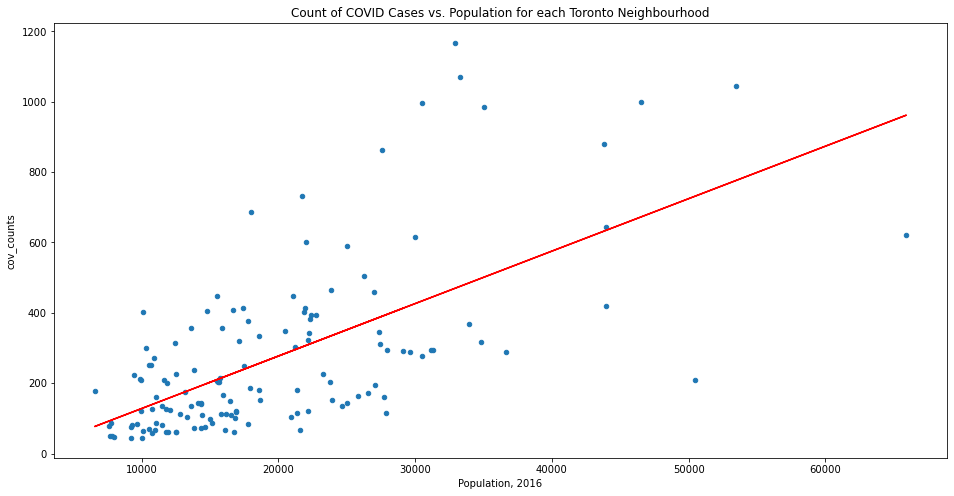

In [17]:
# plot each Neighborhood's COVID count against its population
fig, ax = plt.subplots(figsize=(16,8))
nbhd_cov.plot.scatter("Population, 2016", "cov_counts", ax=ax,
                      title='Count of COVID Cases vs. Population for each Toronto Neighbourhood');
# plot linear regression trend line
plt.plot(X, nbhdpop_cov_LR.predict(X), 'r-');

In [18]:
# carry out Linear Regression with columns 5+
X = nbhd_cov.iloc[:,5:] #.dropna(axis=1)
y = nbhd_cov.cov_counts
# can compare between normalized and non-normalized
nbhd_cov_LR = LinearRegression(normalize=True).fit(X, y)

In [19]:
# predict  the
y_pred = nbhd_cov_LR.predict(X)
nbhd_cov_LR_mse = mean_squared_error(y, y_pred)
nbhd_cov_LR_rmse = np.sqrt(nbhd_cov_LR_mse)
print(nbhd_cov_LR_rmse)

87.83990096897456


Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.
 
```
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(X_test)  # doctest: +SKIP
```

An alternative and recommended approach is to use StandardScaler in a Pipeline

Finding a reasonable regularization parameter  is best done using GridSearchCV, usually in the range 10.0 ** -np.arange(1, 7).

Empirically, we observed that L-BFGS converges faster and with better solutions on small datasets. For relatively large datasets, however, Adam is very robust. It usually converges quickly and gives pretty good performance. SGD with momentum or nesterov’s momentum, on the other hand, can perform better than those two algorithms if learning rate is correctly tuned.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
scaler = StandardScaler()
# Don't cheat - fit only on training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test)

In [22]:
param_grid = [{'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),
             (7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),
            (16,),(17,),(18,),(19,),(20,),(21,)]}]
param_grid = [{'activation' : ['identity'],
            'solver' : ['lbfgs'], 'alpha' : [0.001, 0.002],
            'hidden_layer_sizes': [(1,1),(2,2),(3,3),(5,)]}]
clf = GridSearchCV(MLPRegressor(max_iter=100000), param_grid, cv=2, # use cross-validation of 2 b/c data set is small
                           scoring='neg_root_mean_squared_error')
clf.fit(X,y)

print("Best parameters set found on development set:")
print(clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

Best parameters set found on development set:
{'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (3, 3), 'solver': 'lbfgs'}


In [23]:
print(clf.best_params_)

{'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (3, 3), 'solver': 'lbfgs'}


In [24]:
#nbhd_cov_NN = MLPRegressor(hidden_layer_sizes=(40,40) max_iter=5000, warm_start=True, alpha=0.0001,
#                          ).fit(X_train, y_train)
# L-BFGS was recommended for small datasets
nbhd_cov_NN = MLPRegressor(hidden_layer_sizes=(2,2), solver='lbfgs', max_iter=1000000, alpha=0.001,
                          activation='identity').fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [25]:
y_train_pred = nbhd_cov_NN.predict(X_train)
nbhd_cov_NN_mse = mean_squared_error(y_train, y_train_pred)
nbhd_cov_NN_rmse = np.sqrt(nbhd_cov_NN_mse)
print(nbhd_cov_NN_rmse)

82.02428353044726


In [26]:
y_test_pred = nbhd_cov_NN.predict(X_test)
nbhd_cov_NN_mse = mean_squared_error(y_test, y_test_pred)
nbhd_cov_NN_rmse = np.sqrt(nbhd_cov_NN_mse)
print(nbhd_cov_NN_rmse)

144.85940182238127
